In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

/tmp/ipykernel_1751/3496465029.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import morphology_utils
import cutout_utils
import pipeline_utils


In [4]:
# change to your username
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [9]:
query_str = """
            SELECT *
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 100000
            ORDER BY segmentation_area DESC
            """
job = Euclid.launch_job(query_str)
len(job.results)

2000

In [15]:
# job.results.to_pandas().columns.values
job.results.to_pandas()['segmentation_map_id']

0       102017805201885
1       102025559161992
2       102020580158829
3       102030405086077
4       102020554034848
             ...       
1995    102028752050015
1996    102020582031443
1997    102032688076116
1998    102025036067050
1999    102041101028172
Name: segmentation_map_id, Length: 2000, dtype: int64

## What tiles do we have?

In [5]:
# currently only south and wide have any data


# survey = edf_south
# survey = edf_fornax
# survey = edf_north
survey = pipeline_utils.WIDE

tiles = pipeline_utils.get_tiles_in_survey(survey, bands='VIS')
tiles['tile_index']


INFO: Query finished. [astroquery.utils.tap.core]
Found 1746  query results


0       102010567
1       102010568
2       102010569
3       102010923
4       102010924
          ...    
1741    102165182
1742    102165183
1743    102165188
1744    102165193
1745    102165194
Name: tile_index, Length: 1746, dtype: int64

In [6]:
tiles['instrument_name'].value_counts()

instrument_name
VIS    1746
Name: count, dtype: int64

In [7]:
tiles['release_name'].value_counts()

release_name
F-006           1742
F-003_240321    4   
Name: count, dtype: int64

In [8]:
tiles['filter_name'].value_counts()

filter_name
VIS    1746
Name: count, dtype: int64

In [9]:
# wide_tiling = Table.read('tiling_fields_from_mer/field_all_sky_overview.fits')
deep_south_tiling = Table.read('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/tiling_fields_from_mer/field_deep_sub_14_overview.fits')
deep_fornax_tiling = Table.read('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/tiling_fields_from_mer/field_deep_sub_002_overview.fits')
deep_north_tiling = Table.read('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/tiling_fields_from_mer/field_deep_sub_003_overview.fits')
deep_south_tiling.columns

<TableColumns names=('tilename','folderName','tileId','flavour','comment','RA','Dec','width','height','area','coverfract','nsidec','mocc','nhpc','hpareac','nside','moc','nhp','hparea','min_dist_corner','min_dist_center')>

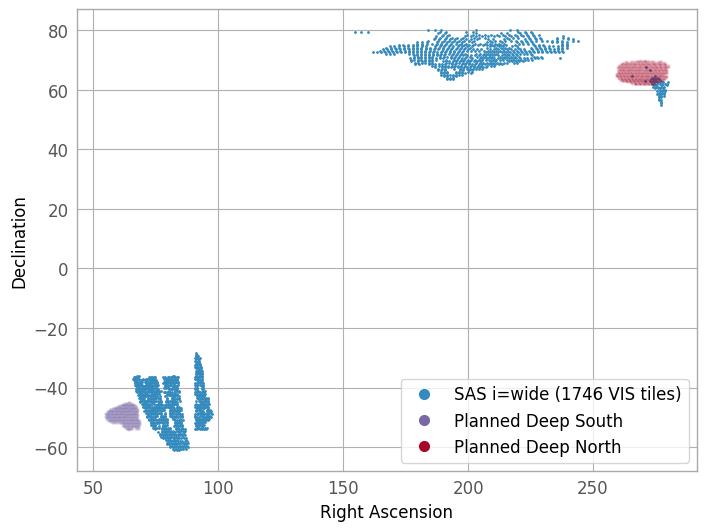

In [10]:
plt.scatter(tiles['ra'], tiles['dec'], s=1.)
plt.scatter(deep_south_tiling['RA'], deep_south_tiling['Dec'], s=1., alpha=.1)
plt.scatter(deep_north_tiling['RA'], deep_north_tiling['Dec'], s=1., alpha=.1)
# plt.scatter(deep_fornax_tiling['RA'], deep_fornax_tiling['Dec'], s=1., alpha=.1)
# plt.scatter(karina_df['target_ra'], karina_df['target_dec'], s=1., alpha=.1)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')


# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# https://matplotlib.org/stable/gallery/color/color_cycle_default.html

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

markersize = 7
legend_elements = [
    Line2D([0], [0],linestyle='', marker='o', color=colors[0], markerfacecolor=colors[0], markersize=markersize, label=f'SAS i={survey.name} ({len(tiles)} VIS tiles)'),
    Line2D([0], [0], linestyle='', marker='o', color=colors[1], markerfacecolor=colors[1], markersize=markersize, label='Planned Deep South'),
    Line2D([0], [0], linestyle='', marker='o', color=colors[2], markerfacecolor=colors[2], markersize=markersize, label='Planned Deep North'),
    # Line2D([0], [0], linestyle='', marker='o', color=colors[3], markerfacecolor=colors[3], markersize=markersize, label='Planned Deep Fornax'),
    # Line2D([0], [0], linestyle='', marker='o', color=colors[4], markerfacecolor=colors[4], markersize=markersize, label='Karina')
]

plt.legend(handles=legend_elements)


In [11]:
# karina_df = pd.read_csv('combined_karina_strong_lens_classifications.csv', usecols=['id_str', 'target_ra', 'target_dec'])

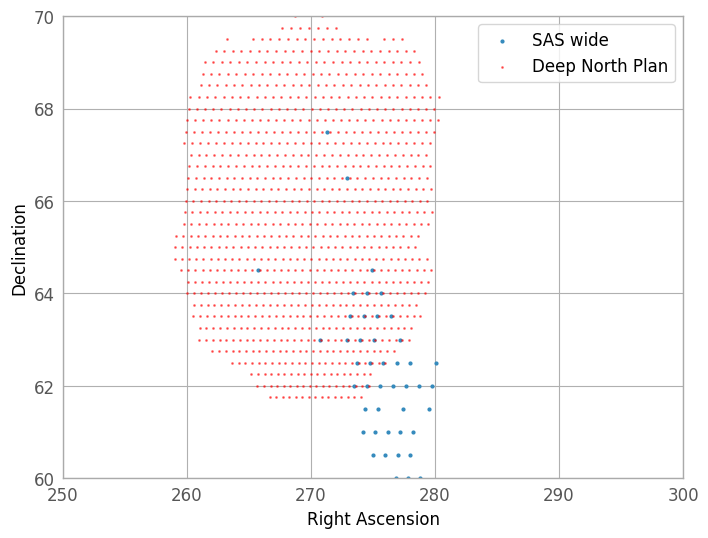

In [12]:
plt.scatter(tiles['ra'], tiles['dec'], s=4., label=f'SAS {survey.name}')
plt.scatter(deep_north_tiling['RA'], deep_north_tiling['Dec'], s=1., color='r', alpha=.5, label='Deep North Plan')
# plt.scatter(karina_df['target_ra'], karina_df['target_dec'], s=1., alpha=.1, label='Karina')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.xlim([250, 300])
plt.ylim([60, 70])
plt.legend()

## What sources do we have in the MER catalogue?

In [13]:
# safe_tiles = vis_tiles.query('ra > 270').query('ra < 280').query('dec > 62.1').query('dec < 70').sort_values(['dec', 'ra'], ascending=False)[['tile_index', 'ra', 'dec']][:14]

In [14]:
# plt.scatter(safe_tiles['ra'], safe_tiles['dec'], s=4., label='SAS')
# plt.scatter(deep_north_tiling['RA'], deep_north_tiling['Dec'], s=1., color='r', alpha=.5, label='Deep North Plan')
# plt.xlabel('Right Ascension')
# plt.ylabel('Declination')
# plt.xlim([250, 300])
# plt.ylim([60, 70])
# plt.legend()

In [15]:
query_str = """
            SELECT right_ascension, declination
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 10000
            ORDER BY segmentation_area DESC
            """
job = Euclid.launch_job_async(query_str, background=False)
len(job.results)

INFO: Query finished. [astroquery.utils.tap.core]


287151

In [16]:
mer_df = job.results
# for now it seems all sources are only in this box of sky

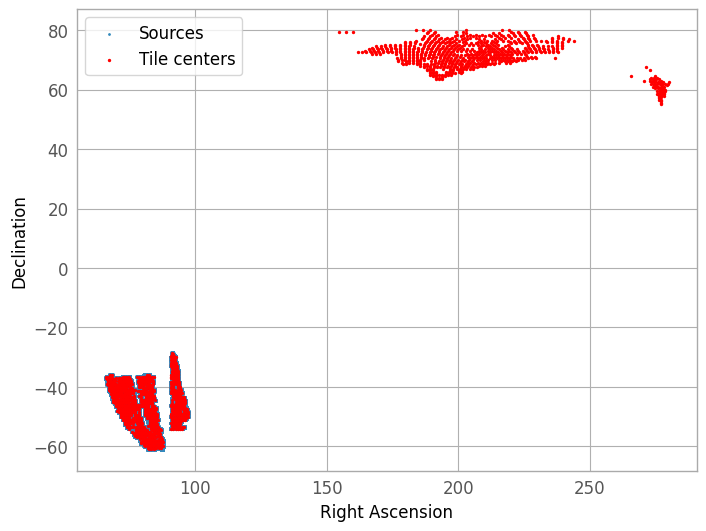

In [17]:
# ra_limits = [mer_df['right_ascension'].min(), mer_df['right_ascension'].max()]
# dec_limits = [mer_df['declination'].min(), mer_df['declination'].max()]

plt.scatter(mer_df['right_ascension'], mer_df['declination'], s=1., label='Sources')
plt.scatter(tiles['ra'], tiles['dec'], s=2., color='r', label='Tile centers')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
# plt.xlim(ra_limits)
# plt.ylim(dec_limits)
plt.legend()
# unlike the tiles, which are in SAS (albeit wrongly indexed), the MER catalogs are only available in SAS for a small corner of the Wide survey

## Get tiles specifically in that area

In [18]:
tiles_with_sources = pipeline_utils.get_tiles_in_survey(survey, bands='VIS', ra_limits=ra_limits, dec_limits=dec_limits)
len(tiles_with_sources)

NameError: name 'ra_limits' is not defined

In [ ]:
plt.scatter(tiles_with_sources['ra'], tiles_with_sources['dec'], s=2., color='r', label='Tile centers')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

In [ ]:
# TODO save these (without VIS filter) and in another notebook, download for making cutouts

## Count sources under various filters

In [ ]:
# help(Euclid.launch_job_async)

In [ ]:
# rand_fraction = 0.01

# ,'point_like_flag','point_like_prob'
# 'binary_flag','blended_prob','deblended_flag',
# 'det_quality_flag',
# 'flag_vis','flag_y'

# query_str = f"""
#             SELECT TOP 10 * 
#             FROM catalogue.mer_catalogue
#             WHERE segmentation_area > 100
#             AND gaia_id IS NULL
#             AND RAND() < {rand_fraction}
#             """
# job = Euclid.launch_job(query_str)
# job.results.columns

In [ ]:
rand_fraction = 0.01

query_str = f"""
            SELECT right_ascension, declination, segmentation_area, flux_segmentation, object_id, spurious_prob, vis_det, det_quality_flag, flag_vis, flag_y
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 100
            AND gaia_id IS NULL
            AND vis_det=1
            AND spurious_prob < 0.2
            AND RAND() < {rand_fraction}
            """
job = Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_mer_catalogue.csv', output_format='csv')

In [ ]:
df = pd.read_csv('latest_mer_catalogue.csv')
len(df), int(len(df) / rand_fraction)

In [ ]:
df

In [ ]:
# plt.scatter(df['right_ascension'], df['declination'])

In [ ]:
# df['spurious_prob'].hist(bins=100)

"the fluxes in MER catalogues are microJy, therefore you don’t need any zeropoint, but only the conversion mag = -2.5*log10(flux[muJy])+23.9"


In [ ]:
df['mag_segmentation'] = -2.5 * np.log10(df['flux_segmentation']) + 23.9

In [ ]:

fig, ax = plt.subplots()
ax.scatter(df['mag_segmentation'], df['segmentation_area'], alpha=.1, s=1.)
ax.set_yscale('log')
plt.xlabel('VIS Mag')
plt.ylabel('Segmentation area (VIS pixels)')
x_min = 18
x_max = 22
y_min = 10**2
y_max = 10**5
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.hlines(1200, 20.5, x_max, linestyle='-', alpha=.7, color='r', label='Area=1200px')
# ax.hlines(800, x_min, 20.5, linestyle='-', alpha=.7, color='r', label='Area=800px')
# ax.hlines(1500, x_min, x_max, linestyle='--', alpha=.5, color='g', label='Area=1500px')
# ax.hlines(2000, x_min, x_max, linestyle='--', alpha=.5, color='orange', label='Area=2000px')
# ax.vlines(20, y_min, y_max, linestyle='--', alpha=.7, color='k', label='VIS=20')
ax.vlines(20.5, y_min, 1200, linestyle='-', alpha=.7, color='g', label='VIS=20.5')


alpha = .05
# color = '#00979D'
color = 'r'
select_x = np.linspace(x_min, x_max)
# select_x_low = select_x[select_x < 20.5]
# select_x_high = np.concatenate([select_x_low[-1].reshape(1), select_x[select_x >= 20.5]])

# ax.fill_between(select_x, np.where(select_x < 20.5, x_min, 1200), y_max, color=color, alpha=alpha)
select_x = np.linspace(20.5, x_max)
ax.fill_between(select_x, y_min, 1200, color=color, alpha=alpha)
ax.text(19.1, 400, 'Complete to VIS=20.5')
ax.text(20.1, 5000, 'Includes faint extended galaxies')
# ax.text(20.1, 5000, 'Dropped', color='r')

plt.legend(loc='upper right')

In [ ]:
len(df)

In [ ]:
df.query('segmentation_area > 1200')['flag_vis']

In [ ]:
df['flag_vis_binary'] = df['flag_vis'].apply(lambda x: "{0:b}".format(x))

In [ ]:
df['flag_vis_contaminated'] = df['flag_vis'].apply(lambda x: x // 2)
df['flag_vis_contaminated'].value_counts()

In [ ]:
df.query('segmentation_area > 1200')['flag_vis_binary']

In [ ]:
df['flag_vis_contaminated'] = df['flag_vis_binary'].apply(lambda x: (x[0] == '1'))
df['flag_vis_contaminated'].value_counts()

In [ ]:
df['flag_vis_blended'] = df['flag_vis_binary'].apply(lambda x: (x[1] == '1') if len(x) > 1 else False)
df['flag_vis_blended'].value_counts()

In [ ]:
df['flag_vis_saturated'] = df['flag_vis_binary'].apply(lambda x: (x[2] == '1') if len(x) > 2 else False)
df['flag_vis_saturated'].value_counts()

In [ ]:
df['flag_vis_border'] = df['flag_vis_binary'].apply(lambda x: (x[3] == '1') if len(x) > 3 else False)
df['flag_vis_border'].value_counts()

In [ ]:
"""
Bit Set
Description
1
Source contaminated by closer neighbors or has bad pixels
2
Source blended with another one (must comply with PARENT_ID ≠ -1)
3
Source saturated
4
Source close to a border

"""

In [ ]:
df.query('segmentation_area > 1200')['flag_vis_binary'].value_counts()
# TODO https://docs.google.com/document/d/16EDD-tvAj5VpKOnD_fsCw6ujixO9gPu8oK_egbWs4hk/edit

In [ ]:
len(df.query('segmentation_area > 1200').query('mag_segmentation < 24')) / rand_fraction

In [ ]:
len(df.query('segmentation_area > 1500').query('mag_segmentation < 24')) / rand_fraction

In [ ]:
len(df.query('segmentation_area > 2000').query('mag_segmentation < 24')) / rand_fraction

In [ ]:
len(df.query('segmentation_area > 1200').query('mag_segmentation < 24').query('spurious_prob < 0.2')) / rand_fraction

In [ ]:
len(df.query('segmentation_area > 1200')) / rand_fraction, len(df.query('segmentation_area > 2000')) / rand_fraction, len(df)/rand_fraction
# about 1M galaxies above 1200, about 500k above 2000, out of 29M (above 100 i.e. 10 pixels across)

In [ ]:
35 ** 2, 45 ** 2

In [ ]:
len(df.query('segmentation_area > 2000').query('segmentation_area < 10000')) / rand_fraction

In [ ]:
vis_data = fits.getdata('testing/EUC_MER_BGSUB-MOSAIC-VIS_TILE102010567-EE51A8_20240306T053728.760996Z_00.00.fits')
vis_data.size  # pixels per tile

In [ ]:
total_survey_pixels = vis_data.size * len(tiles)  # ignoring overlaps
total_survey_pixels

In [ ]:
galaxy_pixels = df['segmentation_area'].sum()
our_galaxy_pixels = df.query('segmentation_area > 1200')['segmentation_area'].sum() 
our_galaxy_pixels / galaxy_pixels

In [ ]:
galaxy_pixels / total_survey_pixels  # about 3% of the sky, ignoring corners

In [ ]:
# Ac = pi r ** 2  As = (2r) ** 2

# np.sqrt(Ac / pi) = np.sqrt(As)/2

# 4Ac / pi = As

# 4Ac = As * pi

# As = 4/pi Ac

# 4/pi factor different

galaxy_pixels * (4/np.pi) / total_survey_pixels

In [ ]:
(len(tiles) * 30 / 60)

In [ ]:
len(tiles) * 30 * 30 / (60*60)